# 数据预处理

1. 标签处理
2. 标签编码
3. 可视化编码过程
4. 定义预处理类

In [0]:
import pandas as pd
import os
import torch as t
import numpy as np
import torchvision.transforms.functional as ff
from torch.utils.data import Dataset
from PIL import Image
import torchvision.transforms as transforms
import matplotlib.pyplot as plt # plt 用于显示图片

**1 处理标签文件中colormap的数据：** dataset.py read_color_map方法

In [0]:
pd_label_color = pd.read_csv('./CamVid/class_dict.csv', sep=',')
pd_label_color

,name,r,g,b
0,Sky,128,128,128
1,Building,128,0,0
2,Pole,192,192,128
3,Road,128,64,128
4,Sidewalk,0,0,192
5,Tree,128,128,0
6,SignSymbol,192,128,128
7,Fence,64,64,128
8,Car,64,0,128
9,Pedestrian,64,64,0


In [0]:
pd_label_color.index

RangeIndex(start=0, stop=12, step=1)

In [0]:
len(pd_label_color.index)

12

In [0]:
# pandas.iloc方法提供了基于整数的索引方式，跟 python自身的list 的索引方式是十分类似
pd_label_color.iloc[2]  # index location

name    Pole
r        192
g        192
b        128
Name: 2, dtype: object

In [0]:
tmp = pd_label_color.iloc[2]
print(tmp['r'])
print(tmp['b'])

192
128


In [0]:
name_value = pd_label_color['name'].values  # ndarray type
print(name_value)
num_class = len(name_value)
num_class

['Sky' 'Building' 'Pole' 'Road' 'Sidewalk' 'Tree' 'SignSymbol' 'Fence'
 'Car' 'Pedestrian' 'Bicyclist' 'unlabelled']


12

In [0]:
# 取出csv文件中的不同物体的颜色映射标签colormap
colormap = []
for i in range(len(pd_label_color.index)):
    # 通过行号索引行数据
    tmp = pd_label_color.iloc[i]
    color = [tmp['r'], tmp['g'], tmp['b']]
    colormap.append(color)
print(colormap)

cm = np.array(colormap).astype('uint8')
cm
# 注意这里的索引对应关系，cm[0] = [128, 128, 128] 这里的索引 0 也对应着 sky 这种标签类别

[[128, 128, 128], [128, 0, 0], [192, 192, 128], [128, 64, 128], [0, 0, 192], [128, 128, 0], [192, 128, 128], [64, 64, 128], [64, 0, 128], [64, 64, 0], [0, 128, 192], [0, 0, 0]]


array([[128, 128, 128],
       [128,   0,   0],
       [192, 192, 128],
       [128,  64, 128],
       [  0,   0, 192],
       [128, 128,   0],
       [192, 128, 128],
       [ 64,  64, 128],
       [ 64,   0, 128],
       [ 64,  64,   0],
       [  0, 128, 192],
       [  0,   0,   0]], dtype=uint8)

**2 标签编码**

　　这里可以对应到算法与数据结构中的`哈希算法`，哈希算法是为了形成一种多对一或一对一的映射关系，从而加快检索和查询的效率（这里只是简单提一下，不影响对课程的整体理解）

　　函数`encode_label_color(colormap)`，形成颜色到标签的一一对应关系，下面使用了类似256进制的方法映射每一个color map里的像素点到它所表示的类别（用哈希函数做了一张哈希表）
* 希函数：(cm[0] * 256 + cm[1]) * 256 + cm[2] 
* 哈希映射：cm2lbl[(cm[0] * 256 + cm[1]) * 256 + cm[2]] = i
* 哈希表：cm2lbl  

　　原理：一个像素点如:`P（128，64，128）`由编码函数`(P[0] * 256 + P[1]) * 256 + P[2]`转化为整数`（8405120）`,将这个数字作为像素点P在cm2lbl表中的索引`cm2lbl[8405120]`去查询像素点`P(128,64,128)`所对应的类别`i`。


In [0]:
def encode_label_pix(colormap):
    cm2lbl = np.zeros(256 ** 3)
    for i, cm in enumerate(colormap):
        cm2lbl[(cm[0] * 256 + cm[1]) * 256 + cm[2]] = i
    return cm2lbl

cm2lbl = encode_label_pix(colormap)
print(cm2lbl)
print(cm2lbl.sum())

[11.  0.  0. ...  0.  0.  0.]
66.0


**2.1可视化标签编码过程**

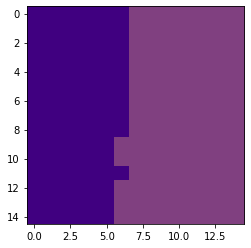

In [0]:
# 从label中扣取一部分展示出来 展示标签是如何制作的
label_path = '/content/CamVid/train_labels/0001TP_006690_L.png'
label = Image.open(label_path).convert('RGB')
label = np.array(label)
demo_label = label[280:295, 280:295, :]  #shape(15,15,3)
plt.imshow(demo_label) # 显示图片
plt.show()

In [0]:
# 对照颜色表，这上图是car和road的分界线
# 上面一小块图像的数值结构
data = np.array(demo_label)
print(data[:, :, 0])
print('--------'*8)
print(data[:, :, 1])
print('--------'*8)
print(data[:, :, 2])

[[ 64  64  64  64  64  64  64 128 128 128 128 128 128 128 128]
 [ 64  64  64  64  64  64  64 128 128 128 128 128 128 128 128]
 [ 64  64  64  64  64  64  64 128 128 128 128 128 128 128 128]
 [ 64  64  64  64  64  64  64 128 128 128 128 128 128 128 128]
 [ 64  64  64  64  64  64  64 128 128 128 128 128 128 128 128]
 [ 64  64  64  64  64  64  64 128 128 128 128 128 128 128 128]
 [ 64  64  64  64  64  64  64 128 128 128 128 128 128 128 128]
 [ 64  64  64  64  64  64  64 128 128 128 128 128 128 128 128]
 [ 64  64  64  64  64  64  64 128 128 128 128 128 128 128 128]
 [ 64  64  64  64  64  64 128 128 128 128 128 128 128 128 128]
 [ 64  64  64  64  64  64 128 128 128 128 128 128 128 128 128]
 [ 64  64  64  64  64  64  64 128 128 128 128 128 128 128 128]
 [ 64  64  64  64  64  64 128 128 128 128 128 128 128 128 128]
 [ 64  64  64  64  64  64 128 128 128 128 128 128 128 128 128]
 [ 64  64  64  64  64  64 128 128 128 128 128 128 128 128 128]]
------------------------------------------------------

In [0]:
# 矩阵化批量操作像素点的编码由（r, g, b） ---> index ---> identity
def encode_label_img(img):
    data = np.array(img, dtype='int32')
    idx = (data[:, :, 0] * 256 + data[:, :, 1]) * 256 + data[:, :, 2]  # 这是一片数字
    print(idx)
    print('----')
    print(cm2lbl[idx])  # 由一片索引带出来的一片表示类别的数值
    return np.array(cm2lbl[idx], dtype='int64')  # 使用numpy 改变一下数据的类型，增加计算精度，int8-->int64

decoded_demo_label = image2label(demo_label)

[[4194432 4194432 4194432 4194432 4194432 4194432 4194432 8405120 8405120
  8405120 8405120 8405120 8405120 8405120 8405120]
 [4194432 4194432 4194432 4194432 4194432 4194432 4194432 8405120 8405120
  8405120 8405120 8405120 8405120 8405120 8405120]
 [4194432 4194432 4194432 4194432 4194432 4194432 4194432 8405120 8405120
  8405120 8405120 8405120 8405120 8405120 8405120]
 [4194432 4194432 4194432 4194432 4194432 4194432 4194432 8405120 8405120
  8405120 8405120 8405120 8405120 8405120 8405120]
 [4194432 4194432 4194432 4194432 4194432 4194432 4194432 8405120 8405120
  8405120 8405120 8405120 8405120 8405120 8405120]
 [4194432 4194432 4194432 4194432 4194432 4194432 4194432 8405120 8405120
  8405120 8405120 8405120 8405120 8405120 8405120]
 [4194432 4194432 4194432 4194432 4194432 4194432 4194432 8405120 8405120
  8405120 8405120 8405120 8405120 8405120 8405120]
 [4194432 4194432 4194432 4194432 4194432 4194432 4194432 8405120 8405120
  8405120 8405120 8405120 8405120 8405120 8405120]


**定义一个类来描述标签像素编码这个行为**

　　将上面介绍的函数功能都整合到一个类里，使代码结构更清晰

In [0]:
class LabelProcessor():
    """对标签图像的编码"""
    def __init__(self, file_path):

        self.colormap = self.read_color_map(file_path)

        self.cm2lbl = self.encode_label_pix(self.colormap)

    def read_color_map(self, file_path):
        pd_label_color = pd.read_csv(file_path, sep=',')
        name_value = pd_label_color['name'].values  # ndarray type
        num_class = len(name_value)

        colormap = []
        for i in range(len(pd_label_color.index)):
            tmp = pd_label_color.iloc[i]
            color = [tmp['r'], tmp['g'], tmp['b']]
            colormap.append(color)
        cm = np.array(colormap).astype('uint8')
        return colormap
  
    def encode_label_pix(self, colormap):
        cm2lbl = np.zeros(256 ** 3)
        for i, cm in enumerate(colormap):
            cm2lbl[(cm[0] * 256 + cm[1]) * 256 + cm[2]] = i
        return cm2lbl

    def encode_label_img(self, img):
    
        data = np.array(img, dtype='int32')
        idx = (data[:, :, 0] * 256 + data[:, :, 1]) * 256 + data[:, :, 2]  
        return np.array(self.cm2lbl[idx], dtype='int64') 

class_dict_path = './CamVid/class_dict.csv'
label_processor = LabelProcessor(class_dict_path)

In [0]:
label_processor.colormap

[[128, 128, 128],
 [128, 0, 0],
 [192, 192, 128],
 [128, 64, 128],
 [0, 0, 192],
 [128, 128, 0],
 [192, 128, 128],
 [64, 64, 128],
 [64, 0, 128],
 [64, 64, 0],
 [0, 128, 192],
 [0, 0, 0]]

In [0]:
label_processor.cm2lbl.sum()

66.0

In [0]:
label_processor.encode_label_img(demo_label)

array([[8, 8, 8, 8, 8, 8, 8, 3, 3, 3, 3, 3, 3, 3, 3],
       [8, 8, 8, 8, 8, 8, 8, 3, 3, 3, 3, 3, 3, 3, 3],
       [8, 8, 8, 8, 8, 8, 8, 3, 3, 3, 3, 3, 3, 3, 3],
       [8, 8, 8, 8, 8, 8, 8, 3, 3, 3, 3, 3, 3, 3, 3],
       [8, 8, 8, 8, 8, 8, 8, 3, 3, 3, 3, 3, 3, 3, 3],
       [8, 8, 8, 8, 8, 8, 8, 3, 3, 3, 3, 3, 3, 3, 3],
       [8, 8, 8, 8, 8, 8, 8, 3, 3, 3, 3, 3, 3, 3, 3],
       [8, 8, 8, 8, 8, 8, 8, 3, 3, 3, 3, 3, 3, 3, 3],
       [8, 8, 8, 8, 8, 8, 8, 3, 3, 3, 3, 3, 3, 3, 3],
       [8, 8, 8, 8, 8, 8, 3, 3, 3, 3, 3, 3, 3, 3, 3],
       [8, 8, 8, 8, 8, 8, 3, 3, 3, 3, 3, 3, 3, 3, 3],
       [8, 8, 8, 8, 8, 8, 8, 3, 3, 3, 3, 3, 3, 3, 3],
       [8, 8, 8, 8, 8, 8, 3, 3, 3, 3, 3, 3, 3, 3, 3],
       [8, 8, 8, 8, 8, 8, 3, 3, 3, 3, 3, 3, 3, 3, 3],
       [8, 8, 8, 8, 8, 8, 3, 3, 3, 3, 3, 3, 3, 3, 3]])

In [0]:
TRAIN_ROOT = './CamVid/train'
TRAIN_LABEL = './CamVid/train_labels'
# VAL_ROOT = './CamVid/val'
# VAL_LABEL = './CamVid/val_labels'
# TEST_ROOT = './CamVid/test'
# TEST_LABEL = './CamVid/test_labels'

def read_file(path):
    files_list = os.listdir(path)
    print(files_list)
    file_path_list = [os.path.join(path, img) for img in files_list]    
    print(file_path_list)
    file_path_list.sort()
    return file_path_list


train_imgs = read_file(TRAIN_ROOT)
train_labels = read_file(TRAIN_LABEL)


['0001TP_006720.png', '0001TP_006810.png', '0001TP_006750.png', '0001TP_006690.png', '0001TP_006780.png']
['./CamVid/train/0001TP_006720.png', './CamVid/train/0001TP_006810.png', './CamVid/train/0001TP_006750.png', './CamVid/train/0001TP_006690.png', './CamVid/train/0001TP_006780.png']
['0001TP_006750_L.png', '0001TP_006720_L.png', '0001TP_006690_L.png', '0001TP_006780_L.png', '0001TP_006810_L.png']
['./CamVid/train_labels/0001TP_006750_L.png', './CamVid/train_labels/0001TP_006720_L.png', './CamVid/train_labels/0001TP_006690_L.png', './CamVid/train_labels/0001TP_006780_L.png', './CamVid/train_labels/0001TP_006810_L.png']


In [0]:
class CamvidDataset(Dataset):
    def __init__(self, file_path=[], crop_size=None):
        """para:
            mode(string): 数据使用模式，是训练数据、验证数据还是测试数据
            file_path(list): 数据和标签路径,列表元素第一个为图片路径，第二个为标签路径
        """
        # 1 正确读入图片和标签路径
        if len(file_path) != 2:
            raise ValueError("同时需要图片和标签文件夹的路径，图片路径在前")
        self.img_path = file_path[0]
        self.label_path = file_path[1] 
        # 2 从路径中取出图片和标签数据的文件名保持到两个列表当中（程序中的数据来源）
        self.imgs = self.read_file(self.img_path)
        self.labels = self.read_file(self.label_path)
        # 3 初始化数据处理函数设置
        self.crop_size = crop_size
        
    
    def __getitem__(self, index):
        img = self.imgs[index]
        label = self.labels[index]
        # 从文件名中读取数据（图片和标签都是png格式的图像数据）
        img = Image.open(img)
        label = Image.open(label).convert('RGB')

        img, label = self.center_crop(img, label, self.crop_size)

        img, label = self.img_transform(img, label)
        # print('处理后的图片和标签大小：',img.shape, label.shape)
        sample = {'img': img, 'label': label}

        return sample

    def __len__(self):
        return len(self.imgs)

    
    def read_file(self, path):
        """从文件夹中读取数据"""
        files_list = os.listdir(path)
        file_path_list = [os.path.join(path, img) for img in files_list]    
        file_path_list.sort()
        return file_path_list

    def center_crop(self, data, label, crop_size):
        """裁剪输入的图片和标签大小"""
        data = ff.center_crop(data, crop_size)
        label = ff.center_crop(label, crop_size)
        return data, label

    def img_transform(self, img, label):
        """对图片和标签做一些数值处理"""
        label = np.array(label)  # 以免不是np格式的数据
        label = Image.fromarray(label.astype('uint8'))
        transform_img = transforms.Compose(
            [
                transforms.ToTensor(),
                transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
            ]
        )
        img = transform_img(img)
        label = label_processor.encode_label_img(label)
        label = t.from_numpy(label)

        return img, label


TRAIN_ROOT = './CamVid/train'
TRAIN_LABEL = './CamVid/train_labels'
crop_size = (352, 480)
Cam_train = CamvidDataset([TRAIN_ROOT, TRAIN_LABEL], crop_size)
# Cam_val = CamvidDataset("val", input_size, img_transform)
# Cam_test = CamvidDataset("test", input_size, img_transform)


In [0]:
num_items = Cam_train.__len__()
print(num_items)

5


In [0]:
Cam_train.__getitem__(4)

{'img': tensor([[[-1.1932, -1.1247, -1.0904,  ..., -1.7754, -1.7412, -1.8268],
          [-1.3644, -1.1589, -1.0904,  ..., -1.7412, -1.7925, -1.8097],
          [-1.4500, -1.2445, -1.1760,  ..., -1.7925, -1.8439, -1.7925],
          ...,
          [-1.8439, -1.8439, -1.8439,  ..., -1.4500, -1.5014, -1.5699],
          [-1.8782, -1.8610, -1.8610,  ..., -1.6042, -1.5870, -1.5870],
          [-1.8439, -1.8439, -1.8439,  ..., -1.7069, -1.6727, -1.5699]],
 
         [[-1.0203, -0.8627, -0.7927,  ..., -1.6681, -1.6331, -1.7381],
          [-1.1779, -0.8978, -0.7927,  ..., -1.6331, -1.6856, -1.7206],
          [-1.2479, -0.9853, -0.8978,  ..., -1.6331, -1.6856, -1.6331],
          ...,
          [-1.7381, -1.7381, -1.7381,  ..., -1.1429, -1.1954, -1.3004],
          [-1.7731, -1.7556, -1.7556,  ..., -1.3004, -1.2829, -1.3179],
          [-1.7381, -1.7381, -1.7381,  ..., -1.4055, -1.3704, -1.3004]],
 
         [[-0.7413, -0.6890, -0.6367,  ..., -1.4036, -1.3339, -1.3861],
          [-0.9156, -

In [0]:
# 在训练的时候使用torch的DataLoader函数加载数据
from torch.utils.data import DataLoader
train_data = DataLoader(Cam_train, batch_size=2, shuffle=True, num_workers=1)
for i, sample in enumerate(train_data):
    print('batch[%d]:' %i)
    print(sample['img'].shape)
    print(sample['label'].shape)

batch[0]:
torch.Size([2, 3, 352, 480])
torch.Size([2, 352, 480])
batch[1]:
torch.Size([2, 3, 352, 480])
torch.Size([2, 352, 480])
batch[2]:
torch.Size([1, 3, 352, 480])
torch.Size([1, 352, 480])
